In [2]:
import numpy as np
import pandas as pd
from scipy import special
from scipy.integrate import quad
from scipy.optimize import minimize
from numba import vectorize
from numpy import linalg as la
from collections import namedtuple

In [3]:
SPEED_OF_LIGHT = 299792458.0 
permittivity = 15.0
conductivity = 3e-2

In [4]:
from model import variables

In [77]:
tari = 6.25
trext = 0
num_of_sym_per_bit = 1
variables_by_tari = variables.get_variables_from_tari(tari)
bitrate = variables.get_bitrate(variables_by_tari.rtcal,
                                variables_by_tari.blf,
                                num_of_sym_per_bit)
preamble = variables.get_preamble(tari, variables_by_tari.rtcal,
                                    variables_by_tari.trcal,
                                    trext, num_of_sym_per_bit)

In [9]:

def dbm2w(value_dbm):
    return 10 ** (value_dbm / 10 - 3)

def w2dbm(value_watt):
    return 10 * np.log10(value_watt) + 30 if value_watt >= 1e-15 else -np.inf

def db2lin(value_db):
    return 10 ** (value_db / 10)

@vectorize
def lin2db(value_linear):
    return 10 * np.log10(value_linear) if value_linear >= 1e-15 else -np.inf

In [8]:
def dipole_rp(*, azimuth, **kwargs):
    """
    Returns dipole directional gain
    :param azimuth:
    :return:
    """
    c = np.cos(azimuth)
    s = np.sin(azimuth)
    if c > 1e-9:
        return np.abs(np.cos(np.pi / 2 * s) / c)
    else:
        return 0.0

In [10]:
def two_ray_path_loss_3d(tx_pos, tx_dir_theta, rx_pos, rx_dir_theta, polarization):
    """
    Computes free space signal attenuation between the transmitter and the receiver in linear scale.
    :param wavelen: a wavelen of signal carrier
    :param time: Time passed from the start of reception
    :param ground_reflection: a function to compute a complex-valued reflection coefficient
    :param tx_velocity: the velocity of the transmitter
    :param tx_dir_phi: the vector pointed the direction with tilt angle equals 0 of the transmitter antenna.
    :param tx_dir_theta: the vector pointed the direction with azimuth angle equals 0 of the transmitter antenna.
    :param tx_pos: a current position of the transmitter.
    :param tx_rp: a radiation pattern of the transmitter
    :param rx_velocity: the velocity of the receiver
    :param rx_dir_phi: the vector pointed the direction with tilt angle equals 0 of the transmitter antenna.
    :param rx_dir_theta: the vector pointed the direction with azimuth angle equals 0 of the transmitter antenna.
    :param rx_pos: a current position of the receiver
    :param rx_rp: a radiation pattern of the receiver
    :return: free space path loss in linear scale
    """

    permittivity = 15.0
    conductivity = 3e-2
    wavelen = SPEED_OF_LIGHT/860e6

    def dipole_rp(*, azimuth, **kwargs):  
        """
        Returns dipole directional gain
        :param azimuth:
        :return:
        """
        c = np.cos(azimuth)
        s = np.sin(azimuth)
        if c > 1e-9:
            return np.abs(np.cos(np.pi / 2 * s) / c)
        else:
            return 0.0

    # LoS - Line-of-Sight, NLoS - Non-Line-of-Sight

    # Ray geometry computation
    ground_normal = np.array([0, 0, 1])
    rx_pos_refl = np.array([rx_pos[0], rx_pos[1], -rx_pos[2]])  # Reflect RX relatively the ground

    d0_vector = rx_pos - tx_pos            # LoS ray vector
    d1_vector = rx_pos_refl - tx_pos       # NLoS ray vector
    d0 = la.norm(d0_vector)                # LoS ray length
    d1 = la.norm(d1_vector)                # NLoS ray length
    d0_vector_tx_n = d0_vector / d0        # LoS ray vector normalized
    d0_vector_rx_n = -d0_vector_tx_n
    d1_vector_tx_n = d1_vector / d1        # NLoS ray vector normalized
    d1_vector_rx_n = np.array([-d1_vector_tx_n[0], -d1_vector_tx_n[1], d1_vector_tx_n[2]])

    # Azimuth and tilt angle computation for computation of attenuation
    # caused by deflection from polar direction
    tx_azimuth_0 = np.arccos(np.dot(d0_vector_tx_n, tx_dir_theta))
    rx_azimuth_0 = np.arccos(np.dot(d0_vector_rx_n, rx_dir_theta))
    tx_azimuth_1 = np.arccos(np.dot(d1_vector_tx_n, tx_dir_theta))
    rx_azimuth_1 = np.arccos(np.dot(d1_vector_rx_n, rx_dir_theta))

    # A grazing angle of NLoS ray for computation of reflection coefficient
    grazing_angle = np.arccos(-1*np.dot(d1_vector_rx_n, ground_normal))

    #relative_velocity = rx_velocity - tx_velocity
    #velocity_pr_0 = np.dot(d0_vector_tx_n, relative_velocity)
    #velocity_pr_1 = np.dot(d1_vector_tx_n, relative_velocity)

    # Attenuation caused by radiation pattern


    g0 = (dipole_rp(azimuth=tx_azimuth_0) * dipole_rp(azimuth=rx_azimuth_0))

    g1 = (dipole_rp(azimuth=tx_azimuth_1) * dipole_rp(azimuth=rx_azimuth_1))

    # Attenuation due to reflections (reflection coefficient) computation

    def _reflection_c_parallel(grazing_angle, permittivity, conductivity, wavelen):
        #eta = permittivity - 60j * wavelen * conductivity
        eta = 15 - 60j * SPEED_OF_LIGHT * 3e-2 / 860e6
        c = np.cos(grazing_angle)
        return (eta - c ** 2) ** 0.5


    def _reflection_c_perpendicular(grazing_angle, permittivity, conductivity, wavelen):
        #eta = permittivity - 60j * wavelen * conductivity
        eta = 15 - 60j * SPEED_OF_LIGHT * 3e-2 / 860e6
        c = np.cos(grazing_angle)
        return (eta - c ** 2) ** 0.5 / eta


    # noinspection PyUnusedLocal
    def reflection_constant(*, grazing_angle, polarization, permittivity, conductivity, wavelen, **kwargs):
        return -1.0 + 0.j


    # noinspection PyUnusedLocal
    # @vectorize
    def reflection(grazing_angle, polarization, permittivity, conductivity, wavelen):
        """
        Computes reflection coefficient from conducting surface with defined grazing angle and supported relative
        permittivity and conductivity of the surface. In order to set type of wave polarization, polarization
        parameter is specified. For parallel to surface polarized wave polarization should set to 1, for perpendicular -
        to 0; for circular - to 0.5. For different type of elliptic polarization use other value in the range of 0..1
        :param grazing_angle: an angle between normal to surface and wave vector
        :param polarization: determine the type of polarization of the grazing wave
        :param permittivity: the relative_permittivity of two media divided by the surface
        :param conductivity: the conductivity of the surface
        :param wavelen: the wave length of the grazing wave
        :return: the reflection coefficient for specified parameters and the given grazing angle
        """
        s = np.sin(grazing_angle)

        if polarization < 0 or polarization > 1:
            return float('nan')

        if polarization != 0:
            c_parallel = _reflection_c_parallel(grazing_angle, permittivity, conductivity, wavelen)
            reflection_parallel = (s - c_parallel) / (s + c_parallel)
        else:
            reflection_parallel = 0.j

        if polarization != 1:
            c_perpendicular = _reflection_c_perpendicular(grazing_angle, permittivity, conductivity, wavelen)
            reflection_perpendicular = (s - c_perpendicular) / (s + c_perpendicular)
        else:
            reflection_perpendicular = 0.j

        return polarization * reflection_parallel + (1 - polarization) * reflection_perpendicular

    r1 = reflection(grazing_angle=grazing_angle, wavelen=wavelen, polarization=polarization, permittivity = 15.0, conductivity = 3e-2)


    #k = 2 * np.pi / wavelen
    k = 18.02426718878446
    return (0.5/k)**2 * np.absolute(   g0/d0*np.exp(-1j*k*d0) +
                                    r1*g1/d1*np.exp(-1j*k*d1))**2


In [ ]:
two_ray_path_loss_3d()

In [11]:
def get_path_loss(self, sender, receiver):

    sender_velocity = np.array((0, 0, 0))
    receiver_velocity = np.array((0, 0, 0))


    # Compute path loss in linear scale
    pl = pyradise.two_ray_path_loss_3d(
        time=0,
        wavelen=SPEED_OF_LIGHT/860e6,
        tx_pos=tx_antenna.position,
        tx_dir_theta=tx_antenna.dir_forward,
        tx_dir_phi=tx_antenna.dir_right,
        tx_rp=tx_antenna.rp,
        tx_velocity=sender_velocity,
        rx_pos=rx_antenna.position,
        rx_dir_theta=rx_antenna.dir_forward,
        rx_dir_phi=rx_antenna.dir_right,
        rx_rp=rx_antenna.rp,
        rx_velocity=receiver_velocity,
        ground_reflection=self.ground_reflection,
        permittivity=self.ground_permittivity,
        conductivity=self.ground_conductivity,
        polarization=tx_antenna.polarization)


    return pyradise.lin2db(pl)

def get_rx_power(path_loss=None, tx_power=None, cable_loss=0, tag_modulation_loss=0):



    
    reader_gain = 8.0
    tag_gain = 2.0
    polarization_loss = -3
    #cable_loss = -1.0
    #tag_modulation_loss = -10.0


    rx_power = (tx_power + tag_modulation_loss +
                cable_loss + reader_gain +
                path_loss + tag_gain + polarization_loss)

    return rx_power

In [12]:
x_reader = 0
y_reader = 0.0
z_reader = 5.0
a = np.pi / 4
forward_dir_reader = (-np.sin(a), 0, -np.cos(a))
#right_dir_reader = (0, -1, 0)
position_reader = (-x_reader, y_reader, z_reader)
polapolarization_reader = 0.5

x_tag = -10.0
y_tag = 0.0
z_tag = 0.5

#tag

polapolarization_tag = 1
reader_tx_power = 31.5

In [13]:
def get_path_loth_for_reader(x):
    return two_ray_path_loss_3d(position_reader, forward_dir_reader, np.array([-x, 0, 0.5]), np.array([1,0,0]), 0.5)
def get_path_loth_for_tag(x):
    return two_ray_path_loss_3d(np.array([-x, 0, 0.5]), np.array([1,0,0]), position_reader, forward_dir_reader, 1)

In [56]:
tx_pos, tx_dir_theta, rx_pos, rx_dir_theta, polarization

18.02426718878446

In [16]:
reader_power = get_rx_power(path_loss=lin2db(get_path_loth_for_reader(3)), tx_power=reader_tx_power)

In [17]:
tag_power = get_rx_power(path_loss=lin2db(get_path_loth_for_tag(3)), tx_power=0)

In [18]:
reader_power + tag_power

-83.42567935029858

In [14]:
def sum_of_rx_power(x):
    reader_power = get_rx_power(path_loss=lin2db(get_path_loth_for_reader(x)), tx_power=reader_tx_power, cable_loss=-1.0, tag_modulation_loss=0)
    tag_power = get_rx_power(path_loss=lin2db(get_path_loth_for_tag(x)), tx_power=0,cable_loss=0, tag_modulation_loss=-10.0)
    return reader_power + tag_power

In [15]:
x = [x for x in np.arange(0, 12, 0.01)]
rx_list = [sum_of_rx_power(x) for x in np.arange(0, 12, 0.01)]

<ipython-input-14-ff128b0e51aa>:2: RuntimeWarning: divide by zero encountered in lin2db
  reader_power = get_rx_power(path_loss=lin2db(get_path_loth_for_reader(x)), tx_power=reader_tx_power, cable_loss=-1.0, tag_modulation_loss=0)
<ipython-input-14-ff128b0e51aa>:3: RuntimeWarning: divide by zero encountered in lin2db
  tag_power = get_rx_power(path_loss=lin2db(get_path_loth_for_tag(x)), tx_power=0,cable_loss=0, tag_modulation_loss=-10.0)


In [16]:
df = pd.DataFrame()
df['x'] = x
df['rx_list'] = rx_list

<AxesSubplot:xlabel='x'>

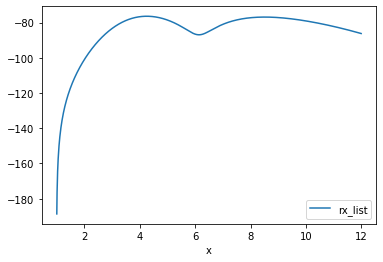

In [84]:
df.plot(x='x', y='rx_list')

<AxesSubplot:xlabel='x'>

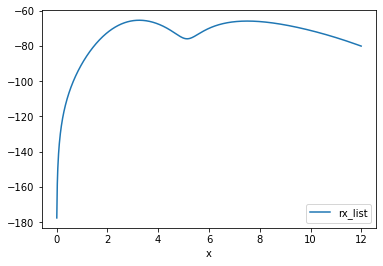

In [17]:
df.plot(x='x', y='rx_list')

In [18]:
def signal2noise(*, rx_power, noise_power, **kwargs):
    """
    Computes Signal-to-Noise ratio. Input parameters are in logarithmic scale.
    :param rx_power:
    :param noise_power:
    :param kwargs:
    :return:
    """
    return db2lin(rx_power - noise_power)
# noinspection PyUnusedLocal
def sync_angle(*, snr, preamble_duration=9.3e-6, bandwidth=1.2e6, **kwargs):
    """
    Computes the angle of de-synchronisation.
    :param snr: an SNR of the received signal
    :param preamble_duration: the duration of PHY-preamble in seconds
    :param bandwidth: the bandwidth of the signal in herzs
    :param kwargs:
    :return: the angle of de-synchronisation
    """
    return (snr * preamble_duration * bandwidth) ** -0.5
# noinspection PyUnusedLocal
def snr_extended(*, snr, sync_phi=0, miller=1, symbol_duration=1.25e-6, bandwidth=1.2e6, **kwargs):
    """
    Computes the extended SNR for BER computation.
    :param snr: an SNR of the received signal
    :param sync_phi: the de-synchronization
    :param miller: the order of Miller encoding
    :param symbol_duration: the symbol duration in seconds
    :param bandwidth: the bandwidth of the signal in herzs
    :param kwargs:
    :return: the extended SNR for BER computation
    """
    return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 2

def get_snr(rx_power, m, preamble_duration, blf):
    noise = (dbm2w(-80) +
                dbm2w(-110))
    noise = w2dbm(noise)
    raw_snr = signal2noise(
        rx_power=rx_power, noise_power=noise)
    sync = sync_angle(
        snr=raw_snr, preamble_duration=preamble_duration)
    snr = snr_extended(
        snr=raw_snr, sync_phi=sync, miller=m,
        symbol_duration=1.0 / blf)
    return snr

def ber_over_awgn(snr):
    """
    Computes BER in an additive white gaussian noise (AWGN) channel for Binary Phase Shift Keying (BPSK)
    :param snr: the extended SNR
    :return:
    """
    def q_function(x):
        return 0.5 - 0.5 * special.erf(x / 2 ** 0.5)

    t = q_function(snr ** 0.5)
    return 2 * t * (1 - t)

def ber_over_rayleigh(snr):
    """
    Computes BER in the channel with Rayleigh fading for Binary Phase Shift Keying (BPSK)
    :param snr:
    :param kwargs:
    :return:
    """
    t = (1 + 2 / snr) ** 0.5
    return 0.5 - 1 / t + 2 / np.pi * np.arctan(t) / t

In [19]:
snr_list = [get_snr(rx_power=rx ,m=num_of_sym_per_bit,
                             preamble_duration=preamble.tag_preamble_len/bitrate.tag_bitrate,
                             blf=variables_by_tari.blf) for rx in rx_list]
ber = [ber_over_rayleigh(snr) for snr in snr_list]
ber_df = pd.DataFrame()
ber_df['x'] = x
ber_df['ber'] = ber

<ipython-input-18-d88ded72d3e9>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
<ipython-input-18-d88ded72d3e9>:33: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 2


In [20]:
ber_df = pd.DataFrame()
ber_df['x'] = x
ber_df['ber'] = ber

<AxesSubplot:xlabel='d, m', ylabel='BER'>

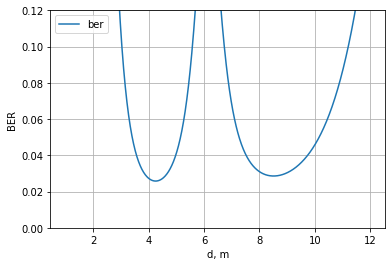

In [167]:
ber_df.plot(x='x',ylim=(0, 0.12), xlabel='d, m', ylabel='BER', grid=True)

<AxesSubplot:xlabel='d, m', ylabel='BER'>

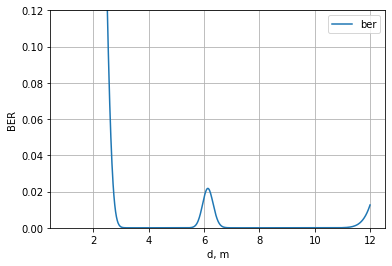

In [160]:
ber_df.plot(x='x',ylim=(0, 0.12), xlabel='d, m', ylabel='BER', grid=True)

<AxesSubplot:xlabel='d, m', ylabel='BER'>

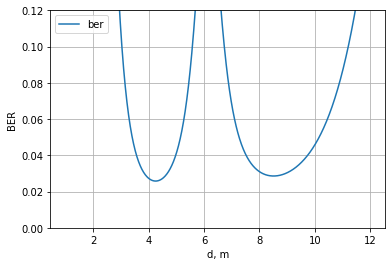

In [170]:
ber_df.plot(x='x', ylim=(0,0.12), xlabel='d, m', ylabel='BER', grid=True)

In [173]:
ber_df['x']

0        0.00
1        0.01
2        0.02
3        0.03
4        0.04
        ...  
1195    11.95
1196    11.96
1197    11.97
1198    11.98
1199    11.99
Name: x, Length: 1200, dtype: float64

In [33]:
name_col = ['FM0', 'M2', 'M4', 'M8']
num_of_sym_per_bit_list = [1, 2, 4, 8]
trext = 0
ber_df = pd.DataFrame()
ber_df['x'] = x
def get_plot_ber(tari):
    i = 0
    variables_by_tari = variables.get_variables_from_tari(tari)
    for m in num_of_sym_per_bit_list:
        bitrate = variables.get_bitrate(variables_by_tari.rtcal,
                                    variables_by_tari.blf,
                                    m)
        preamble = variables.get_preamble(tari, variables_by_tari.rtcal,
                                        variables_by_tari.trcal,
                                        trext, m)
        snr_list = [get_snr(rx_power=rx ,m=m,
                                        preamble_duration=preamble.tag_preamble_len/bitrate.tag_bitrate,
                                        blf=variables_by_tari.blf) for rx in rx_list]

                                    
        ber = [ber_over_rayleigh(snr) for snr in snr_list]
        ber_df[name_col[i]] = ber
        i+=1
    ber_df.plot(x='x', ylim=(0,0.12), xlabel='d, m', ylabel='BER', grid=True)
    

<ipython-input-18-d88ded72d3e9>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
<ipython-input-18-d88ded72d3e9>:33: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 2


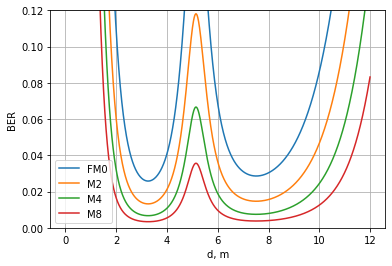

In [27]:
get_plot_ber(6.25)

<ipython-input-154-d88ded72d3e9>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
<ipython-input-154-d88ded72d3e9>:33: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 2


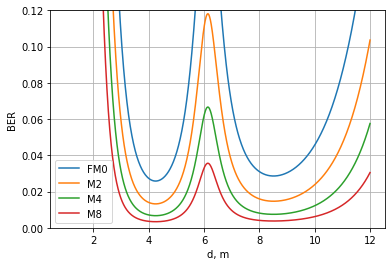

In [184]:
get_plot_ber(6.25)

<ipython-input-154-d88ded72d3e9>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
<ipython-input-154-d88ded72d3e9>:33: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 2


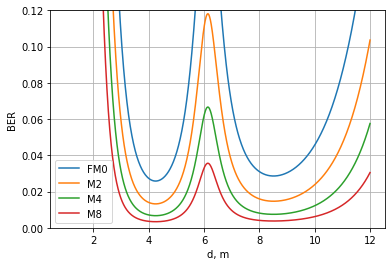

In [185]:
pic = get_plot_ber(6.25)

In [39]:
def build_B(a1, a2, b1, b2, L0, x1, x2, x):
    if x < L0:
        return a1 + b1 * (x - x1)**2
    return a2 + b2 * (x - x2)**2

In [40]:
def ber_func_from_x(x):
    rx = sum_of_rx_power(x)
    snr = get_snr(rx_power=rx,m=num_of_sym_per_bit,
                                preamble_duration=preamble.tag_preamble_len/bitrate.tag_bitrate,
                                blf=variables_by_tari.blf)
    return ber_over_rayleigh(snr)
    

In [36]:
ber_func_from_x(5)

0.18485356554448673

In [47]:
L = 12
def integ(x_opt):
    #a1, a2, b1, b2, L0, x1, x2
    #0-a1, 1-a2, 2-b1, 3-b2, 4-L0, 5-x1, 6-x2
    def fn(x):
        a1 = build_B(x_opt[0], x_opt[1], x_opt[2], x_opt[3], x_opt[4], x_opt[5], x_opt[6], x)
        a2 = ber_func_from_x(x)
        return (a1 - a2) ** 2
    return quad(fn, 0, L)[0]

In [55]:
res_bfgs = minimize(integ, x_opt_0, method='BFGS', bounds=bnds, options={'xtol': 1e-5, 'disp': True})

<ipython-input-55-84ad56d9b414>:1: OptimizeWarning: Unknown solver options: xtol
  res_bfgs = minimize(integ, x_opt_0, method='BFGS', bounds=bnds, options={'xtol': 1e-5, 'disp': True})
Optimization terminated successfully.
         Current function value: 0.027721
         Iterations: 20
         Function evaluations: 200
         Gradient evaluations: 25


In [49]:
bnds = ((0, 0.1), (0, 0.1), (0, 3), (0, 3), (0, 10), (0, 12), (0,12))

In [43]:
x_opt_0 = (0.02, 0.02, 0.1, 0.1, 6, 4, 9)

In [44]:
ber_func_from_x(5)

0.18485356554448673

In [56]:
res_bfgs

      fun: 0.02772086209780983
 hess_inv: array([[ 1.40489431e-01,  1.04662344e-02, -2.12066625e-02,
        -1.47831565e-03,  0.00000000e+00,  1.83039439e-01,
        -4.00250577e-02],
       [ 1.04662344e-02,  1.35931556e-01, -1.43625188e-03,
        -1.78336662e-02,  0.00000000e+00,  5.28054495e-02,
        -3.48929591e-01],
       [-2.12066625e-02, -1.43625188e-03,  1.04273613e-02,
         2.79152958e-04,  0.00000000e+00, -2.30997297e-01,
         2.11295552e-02],
       [-1.47831565e-03, -1.78336662e-02,  2.79152958e-04,
         1.14312287e-02,  0.00000000e+00, -1.04758754e-02,
         8.27251678e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.83039439e-01,  5.28054495e-02, -2.30997297e-01,
        -1.04758754e-02,  0.00000000e+00,  9.16906210e+00,
        -8.44293774e-01],
       [-4.00250577e-02, -3.48929591e-01,  2.11295552e-02,
         8.27251678e-01,  0.0000000

In [58]:
compare_df = pd.DataFrame()
compare_df['d, m'] = [x for x in np.arange(0, 12, 0.01)]
compare_df['apr_BER'] = [build_B(0.0361709, 0.01968352, 0.04023841, 0.01624674, 6, 3.8756385, 7.81955679, x) for x in np.arange(0,12, 0.01)]
compare_df['estim_BER'] = [ber_func_from_x(x) for x in np.arange(0, 12, 0.01)]


<ipython-input-14-ff128b0e51aa>:2: RuntimeWarning: divide by zero encountered in lin2db
  reader_power = get_rx_power(path_loss=lin2db(get_path_loth_for_reader(x)), tx_power=reader_tx_power, cable_loss=-1.0, tag_modulation_loss=0)
<ipython-input-14-ff128b0e51aa>:3: RuntimeWarning: divide by zero encountered in lin2db
  tag_power = get_rx_power(path_loss=lin2db(get_path_loth_for_tag(x)), tx_power=0,cable_loss=0, tag_modulation_loss=-10.0)
<ipython-input-18-d88ded72d3e9>:20: RuntimeWarning: divide by zero encountered in double_scalars
  return (snr * preamble_duration * bandwidth) ** -0.5
<ipython-input-18-d88ded72d3e9>:33: RuntimeWarning: invalid value encountered in cos
  return miller * snr * symbol_duration * bandwidth * np.cos(sync_phi) ** 2


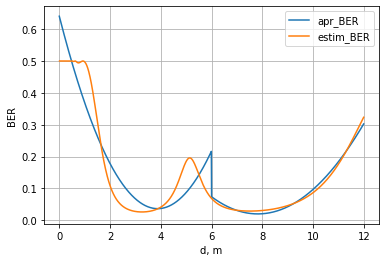

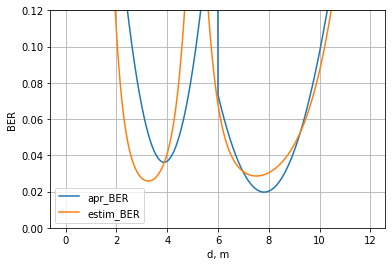

In [74]:
compare_df.plot(x='d, m', ylabel='BER', grid=True)
pic_to_safe = compare_df.plot(x='d, m', ylabel='BER', ylim=(0,0.12), grid=True)


In [72]:
fig = pic_to_safe.

In [73]:
from matplotlib import pyplot as plt

fig.savefig('compare_ber.png')


In [177]:
tari = 6.25e-6
T0 = 22 * 1.25 * tari
T1 = 3 * tari
T3 = T1

def num_int(Q, Q1, Q2, V, dt, T, L, B):
    def fn(x):
        k1 = np.exp(-B(x) * Q)
        k2 = Q2 * tari * np.exp(-B(x) * Q1)
        if k2 <= (T0 + T1 + T3):
            k2 = (T0 + T1 + T3)
        return k1 / (V*k2)
    t = quad(fn, V*T, L)[0]
    

    return 1 - np.exp(-t)

def build_B_new(a1, a2, b1, b2, L0, x1, x2):
    def fn(x):
        if x < L0:
            return a1 + b1 * (x - x1)**2
        return a2 + b2 * (x - x2)**2
    return fn

In [179]:
B = build_B_new(
    a1=0.0361709,
    a2=0.01968352,
    b1=0.04023841,
    b2=0.01624674,
    L0=6.0,
    x1=3.8756385,
    x2=7.81955679
)
m = 1
DR = 64 / 3
tari = 6.25e-6
N0 = 22 * 1.25
N1 = 3 + (16+10)*3*m/DR + 3.75
N2 = 18*1.25 + (128+10)*3*m/DR + 3.75 + N1
num_int(
    Q1=8.27860441,
    Q2=105.4439353,
    Q=16+128,
    V=40,
    T=(N0 + N2) * tari,
    dt=tari,
    L=12,
    B=B,
)

0.9646764955685732

In [186]:
plot_theor = pd.DataFrame()
plot_theor['v, m/s'] = [v for v in range(1, 50)]
plot_theor['tari 6.25, m = 1'] = [num_int(Q1=8.27860441, Q2=105.4439353, Q=16+128, V=v, T=(N0+N2)*tari, dt=tari, L=12, B=B) for v in range(1, 50)]

In [181]:
num_int(Q1=8.27860441, Q2=105.4439353, Q=16+128, V=30, T=(N0+N2)*tari, dt=tari, L=12, B=B)

0.9884099570229706

<AxesSubplot:title={'center':'Probability'}, xlabel='v, m/s', ylabel='p'>

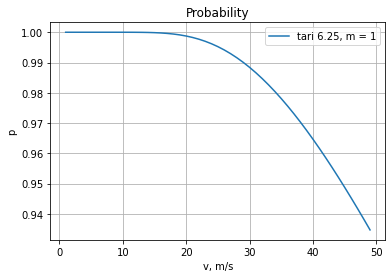

In [189]:
plot_theor.plot(x='v, m/s', ylabel='p', grid=True, title='Probability')

Строю графики P_m и t_m

In [154]:
def compare_speed_function(B):
    Q1=8.27860441
    Q2=105.4439353
    Q= 16 + 128
    df = pd.DataFrame()
    p_m = []
    t_m = []
    for x in np.arange(0, 12, .01):
        k1 = np.exp(-B(x) * Q)
        k2 = 30 * Q2 * tari * np.exp(-B(x) * Q1)
        if k2 <= 30*(T0 + T1 + T3):
            k2 = 30*(T0 + T1 + T3)
        p_m.append(k1)
        t_m.append(k2)
    df['x'] = [x for x in np.arange(0, 12, 0.01)]
    df['p_m'] = p_m
    df['t_m'] = t_m
    return df
        
        

<AxesSubplot:xlabel='x'>

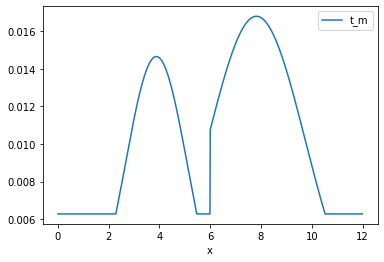

In [151]:
compare_speed_function(B).plot(x='x', y='t_m')

<AxesSubplot:xlabel='x'>

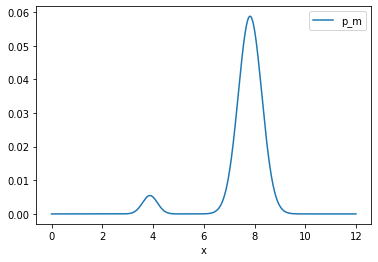

In [152]:
compare_speed_function(B).plot(x='x', y='p_m')

<AxesSubplot:xlabel='x'>

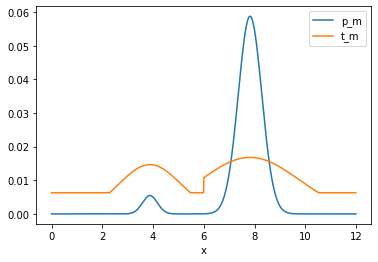

In [153]:
compare_speed_function(B).plot(x='x')

In [148]:
compare_speed_function(B)

,x,p_m,t_m
0,0.00,0.000035,0.006281
1,0.01,0.000037,0.006281
2,0.02,0.000039,0.006281
3,0.03,0.000041,0.006281
4,0.04,0.000043,0.006281
...,...,...,...
1195,11.95,0.008653,0.006281
1196,11.96,0.008469,0.006281
1197,11.97,0.008289,0.006281
1198,11.98,0.008112,0.006281


In [149]:
(1 - 0.05) ** 16

0.44012666865176536